In [8]:
%load_ext autoreload
%autoreload 2
import terra
import numpy as np
import seaborn as sns
from domino.evaluate import run_sdm, score_sdms

import matplotlib.pyplot as plt
from meerkat.contrib.imagenet import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from domino.evaluate import run_sdm, score_sdms

df = score_sdms.out().load()

In [11]:
df

,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,recall,precision,target_synset,run_sdm_run_id,slice
0,0,0,0.245725,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,musical_instrument.n.01,11660,drum.n.01
1,1,0,0.222342,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,musical_instrument.n.01,11660,drum.n.01
2,2,0,0.907018,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.616667,0.011301,musical_instrument.n.01,11660,drum.n.01
3,3,0,0.250994,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,musical_instrument.n.01,11660,drum.n.01
4,4,0,0.851004,0.0,0.00,0.01,0.000000,0.016667,0.016667,0.383333,0.006570,musical_instrument.n.01,11660,drum.n.01
5,0,0,0.951153,0.2,0.16,0.10,0.083333,0.166667,0.216667,1.000000,0.009144,musical_instrument.n.01,11659,drum.n.01
6,1,0,0.185217,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,musical_instrument.n.01,11659,drum.n.01
7,2,0,0.500000,0.0,0.04,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,musical_instrument.n.01,11659,drum.n.01
8,3,0,0.500000,0.0,0.04,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,musical_instrument.n.01,11659,drum.n.01
9,4,0,0.838957,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,musical_instrument.n.01,11659,drum.n.01


In [10]:
df.iloc[df.reset_index().groupby(["run_sdm_run_id", "slice_idx"])['auroc'].idxmax().astype(int)]

,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,recall,precision,target_synset,run_sdm_run_id,slice
20,0,0,0.997347,0.7,0.68,0.57,0.288462,0.548077,0.903846,1.000000,0.012566,vehicle.n.01,11655,vessel.n.02
18,3,0,0.951412,0.9,0.64,0.21,0.281250,0.328125,0.437500,0.062500,0.800000,musical_instrument.n.01,11656,chime.n.01
27,2,0,0.996502,0.8,0.76,0.54,0.307692,0.519231,0.846154,0.884615,0.219048,vehicle.n.01,11657,vessel.n.02
10,0,0,0.978471,0.9,0.72,0.34,0.437500,0.531250,0.625000,0.968750,0.019955,musical_instrument.n.01,11658,chime.n.01
5,0,0,0.951153,0.2,0.16,0.10,0.083333,0.166667,0.216667,1.000000,0.009144,musical_instrument.n.01,11659,drum.n.01
2,2,0,0.907018,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.616667,0.011301,musical_instrument.n.01,11660,drum.n.01
32,2,0,0.978023,0.2,0.12,0.22,0.096154,0.211538,0.423077,0.990385,0.012332,bird.n.01,11661,drake.n.02
36,1,0,0.918221,0.0,0.04,0.08,0.048077,0.076923,0.173077,1.000000,0.011463,bird.n.01,11662,drake.n.02
49,4,0,0.869981,0.0,0.00,0.00,0.000000,0.000000,0.000000,1.000000,0.009002,food.n.01,11663,concoction.n.01
40,0,0,0.849143,0.0,0.00,0.00,0.000000,0.000000,0.000000,1.000000,0.009002,food.n.01,11664,concoction.n.01


In [2]:
inp = run_sdm.inp(run_id=6861, load=True)
data_dp, emb_dp = inp["data_dp"], inp["emb_dp"]

if True:
    from domino.emb.clip import pca_embeddings
    emb_dp = pca_embeddings.out().load()

data_dp = data_dp.lz[data_dp["split"].isin(["valid", "test"])].merge(
    emb_dp[["image_id", "emb_128", "emb"]], on="image_id"
)

In [5]:
from domino.sdm import MixtureModelSDM, SpotlightSDM
sdm = MixtureModelSDM(
    n_slices=5, 
    n_clusters=25, 
    weight_y_log_likelihood=10, 
    init_params="error",
    emb="emb",
    pca_components=128 
)

sdm.fit(data_dp.lz[data_dp["split"] == "valid"])
dp = sdm.transform(data_dp.lz[data_dp["split"] == "test"])

 86%|████████▌ | 86/100 [00:13<00:02,  6.48it/s]


In [4]:
from domino.metrics import compute_sdm_metrics
slice_idx = 0
metrics_df = compute_sdm_metrics(dp)
metrics_df[metrics_df["slice_idx"] == slice_idx].sort_values(by="auroc", ascending=False)

/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,recall,precision
3,3,0,0.999450,1.0,1.0,0.51,0.811321,0.962264,0.981132,1.0,0.00784
2,2,0,0.194263,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.00000
1,1,0,0.074105,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.00000
4,4,0,0.069361,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.00000
0,0,0,0.066414,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.00000


In [14]:
from domino.emb.clip import embed_words
from domino.explain import explain_slice

pred_slice_idx = 4
words_dp = embed_words.out(5143).load()
expl_dp = explain_slice(slice_dp=dp, words_dp=words_dp.lz[:int(1.1e4)], slice_idx=pred_slice_idx)
expl_dp.lz[(-expl_dp["score"]).argsort()[:10]]

KeyError: 'Column `emb` does not exist.'

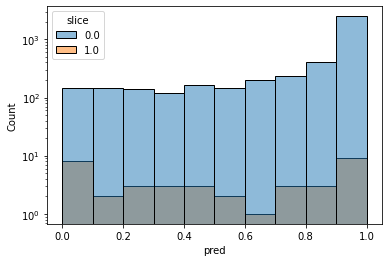

In [17]:
plot_df = pd.DataFrame(
    {"pred": dp["pred"], "slice": dp["slices"][:, slice_idx], "target": dp["target"]}
)
sns.histplot(
    data=plot_df[plot_df["target"] == 1],
    x="pred",
    hue="slice",
    stat="count",
    common_norm=not False,
    binwidth=0.1,
)
plt.yscale("log")


,image_id (PandasSeriesColumn),path (PandasSeriesColumn),index (PandasSeriesColumn),image (ImageColumn),name (PandasSeriesColumn),synset_pos_offset (PandasSeriesColumn),synset (PandasSeriesColumn),target (NumpyArrayColumn),slices (NumpyArrayColumn),input (ImageColumn),id (PandasSeriesColumn),pred (NumpyArrayColumn),split (PandasSeriesColumn),emb (NumpyArrayColumn),pred_slices (NumpyArrayColumn)
0,n07753592_6207,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07753592/n07753592_6207.JPEG,1222459,,banana,n07753592,banana.n.02,1.0,"np.ndarray(shape=(1,))",,n07753592_6207,0.987909,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
1,n07753592_7688,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07753592/n07753592_7688.JPEG,1222588,,banana,n07753592,banana.n.02,1.0,"np.ndarray(shape=(1,))",,n07753592_7688,0.326527,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
2,n07753592_19667,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07753592/n07753592_19667.JPEG,1222033,,banana,n07753592,banana.n.02,1.0,"np.ndarray(shape=(1,))",,n07753592_19667,0.999998,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
3,ILSVRC2012_val_00012444,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00012444.JPEG,1317458,,banana,n07753592,banana.n.02,1.0,"np.ndarray(shape=(1,))",,ILSVRC2012_val_00012444,0.999728,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
4,n07753592_11489,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07753592/n07753592_11489.JPEG,1221618,,banana,n07753592,banana.n.02,1.0,"np.ndarray(shape=(1,))",,n07753592_11489,0.344998,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,n07753592_18276,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07753592/n07753592_18276.JPEG,1221992,,banana,n07753592,banana.n.02,1.0,"np.ndarray(shape=(1,))",,n07753592_18276,0.940143,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
8,ILSVRC2012_val_00046575,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00046575.JPEG,1302949,,banana,n07753592,banana.n.02,1.0,"np.ndarray(shape=(1,))",,ILSVRC2012_val_00046575,0.556941,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
9,n07753592_14549,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07753592/n07753592_14549.JPEG,1221806,,banana,n07753592,banana.n.02,1.0,"np.ndarray(shape=(1,))",,n07753592_14549,0.057113,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
10,n07753592_16846,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07753592/n07753592_16846.JPEG,1221931,,banana,n07753592,banana.n.02,1.0,"np.ndarray(shape=(1,))",,n07753592_16846,0.714703,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"

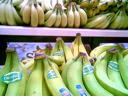
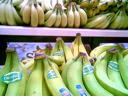
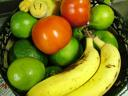
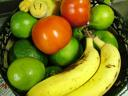
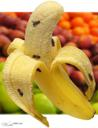
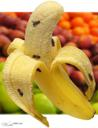
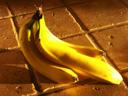
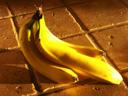
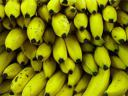
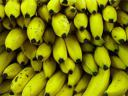
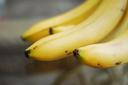
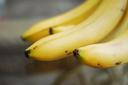
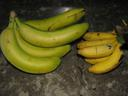
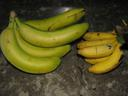
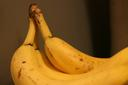
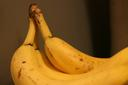
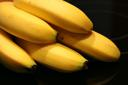
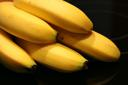
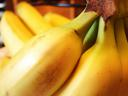
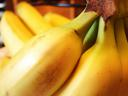

In [18]:
dp.lz[dp["pred_slices"].data[:, pred_slice_idx].argsort()[-12:]]#[["object_image", "target", "slice"]]

In [32]:
words_dp = embed_words.out(5143).load()


In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=128)

In [35]:
pca.fit(words_dp["emb"].lz[:10_000])

PCA(n_components=128)

In [37]:
inp = run_sdm.inp(run_id=6875, load=True)
data_dp, emb_dp = inp["data_dp"], inp["emb_dp"]

In [4]:
pd.read_feather("/home/sabri/terra/slice/tasks/slices/abstract/build_setting/_runs/7193/artifacts/7f4f6b4933ab4b27b2343b2ee4761bc7/mgr/blocks/140387452303392/data.feather")

,path,name,synset_pos_offset,synset,id,index,split,image_id
0,/home/common/datasets/imagenet/ILSVRC/Data/CLS...,yawl,n04612504,yawl.n.01,n04612504_36314,1170870,train,n04612504_36314
1,/home/common/datasets/imagenet/ILSVRC/Data/CLS...,car mirror,n02965783,car_mirror.n.01,n02965783_2503,610549,train,n02965783_2503
2,/home/common/datasets/imagenet/ILSVRC/Data/CLS...,snowmobile,n04252077,snowmobile.n.01,n04252077_1975,1027836,train,n04252077_1975
3,/home/common/datasets/imagenet/ILSVRC/Data/CLS...,"Saint Bernard, St Bernard",n02109525,saint_bernard.n.01,n02109525_10382,315933,train,n02109525_10382
4,/home/common/datasets/imagenet/ILSVRC/Data/CLS...,padlock,n03874599,padlock.n.01,n03874599_412,891881,test,n03874599_412
...,...,...,...,...,...,...,...,...
99994,/home/common/datasets/imagenet/ILSVRC/Data/CLS...,"barrow, garden cart, lawn cart, wheelbarrow",n02797295,barrow.n.03,n02797295_13144,549607,valid,n02797295_13144
99995,/home/common/datasets/imagenet/ILSVRC/Data/CLS...,water snake,n01737021,water_snake.n.01,n01737021_12810,75328,train,n01737021_12810
99996,/home/common/datasets/imagenet/ILSVRC/Data/CLS...,hourglass,n03544143,hourglass.n.01,n03544143_15035,775329,train,n03544143_15035
99997,/home/common/datasets/imagenet/ILSVRC/Data/CLS...,ambulance,n02701002,ambulance.n.01,n02701002_5217,523229,train,n02701002_5217
